In [1]:
%matplotlib notebook

Plot traces and boxplots similar to Figure 1

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from pathlib import Path
from natsort import natsorted
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from scipy import stats
import statsmodels.api as sm
from scipy.signal import savgol_filter
import matplotlib.ticker as plticker


# to import package in parent folder first add the parent folder to path
import sys
import os
packages_path = Path(os.path.dirname(os.path.realpath('__file__'))).parent
sys.path.insert(0, str(packages_path))

import shared_func

In [3]:
home_path = os.getcwd()

filepath = Path(home_path, 'Fig4_data')
savepath = Path(home_path, 'plots')
stat_savepath = Path(home_path, 'stats')

Path(savepath).mkdir(parents=True, exist_ok=True) 
Path(stat_savepath).mkdir(parents=True, exist_ok=True) 

# different light intensities

Need to define the color before I can plot the first figure. That's why this plot comes before plotting the ATR+/- comparison

In [4]:
filename = 'Fig4EF_attP5'

data = np.load(Path(filepath, filename + '.npy'))
adult=True
# and also read the metadata to have everything in one place
with open(Path(filepath, filename + '.txt')) as f:
    metadata = f.read()
    print(metadata)
# Aquisition rate on the Bergamo II scope
aq_rate = 1/0.140757247 # copy paste from csv file, time for each frame

This numpy array contains the data to create Figure 3E/F 
which shows response of control animals with UAS-Chrimson in su(Hw)attP5
at 72uW/mm2, 288uW/mm2 and 1151uW/mm2 with 660nm stimulation light.

Output data is organized the following way:

1st dimension is 210. These are the datapoints 

2nd dimension is 8. These are: Time, Stim, df/f1, df/f2, df/f3, df/f4, df/f5, df/f6. 
Each df/f is a repeat on the same animal 

3rd dimension is 6, one for each animal 

4th dimension is 3. These are: 72uW/mm2, 288uW/mm2 and 1151uW/mm2 

5th dimension is 1.


<IPython.core.display.Javascript object>


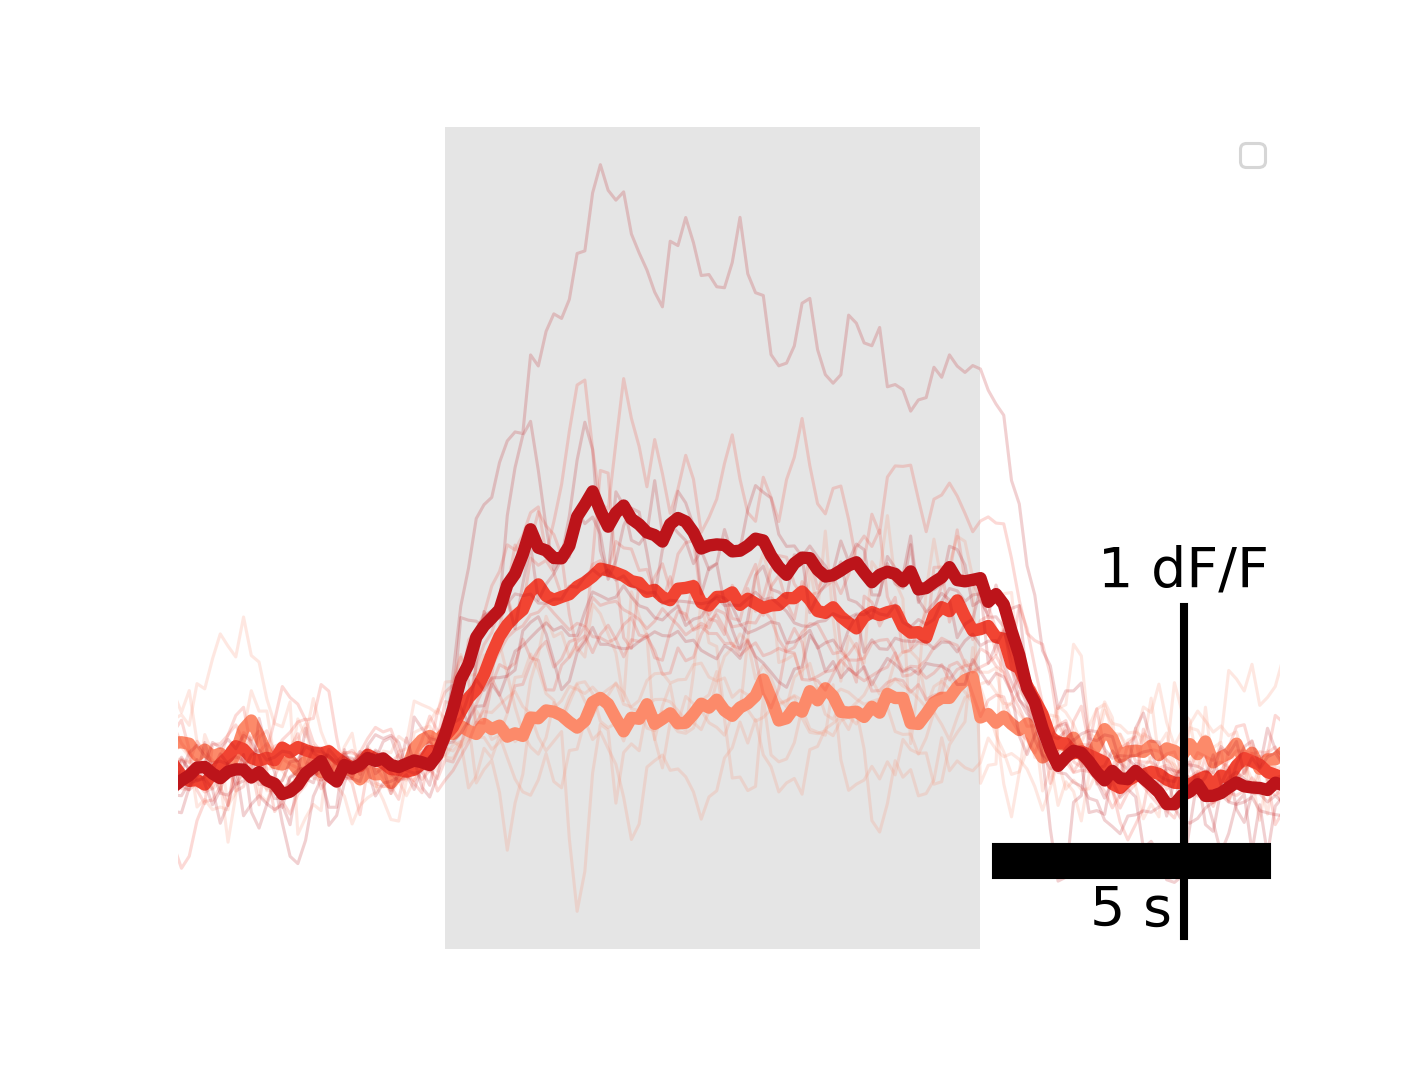

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [5]:
# Define colors used for this plot
start = 0.4
stop = 0.8
number_of_lines= data.shape[3]
cm_subsection = np.linspace(start, stop, number_of_lines) 

colors = [matplotlib.cm.Reds(x) for x in cm_subsection ]
colors = np.array(colors)

# Prepare the raw data for plotting
median_per_animal = shared_func.median_per_animal_func(aq_rate=aq_rate, data=data)

# Then, plot the trace plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Here we have only one group
group = 0

for stim_intensity in range(data.shape[3]):

    ax.plot(data[:,0,0,stim_intensity,group], median_per_animal[:,:,stim_intensity,group], lw=1, zorder=1, 
            color=colors[stim_intensity], alpha=0.2)
    # and plot the mean of the median in bold
    ax.plot(data[:,0,0,stim_intensity,group], np.mean(median_per_animal[:,:,stim_intensity,group], axis=1), 
            lw=4, zorder=1, color=colors[stim_intensity])

# Plot stimulus
start_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][0]
stop_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][-1]
ax.axvspan(data[start_stim, 0, 0, stim_intensity, 0],
           data[stop_stim, 0, 0, stim_intensity, 0],
           lw=0, zorder=0,
           color='k',
           alpha=0.1)
ax.set_xlim(5,25)

fontprops = fm.FontProperties(size=18)
scalebar_time = AnchoredSizeBar(ax.transData,
                                5, '5 s', 'lower right',
                                pad=0.1,
                                color='black',
                                frameon=False,
                                size_vertical=0.1,
                                fontproperties=fontprops)

scalebar_df = AnchoredSizeBar(ax.transData,
                              0.1, '1 dF/F', 'lower right',
                              pad=0.1,
                              color='black',
                              frameon=False,
                              size_vertical=1,
                              fontproperties=fontprops,
                              label_top=True)

ax.add_artist(scalebar_time)
ax.add_artist(scalebar_df)
ax.legend()
ax.axis('off')

savename = 'Fig4_E.svg'
fig.savefig(Path(savepath, savename),
           transparent=True)

In [6]:
# Median values before and during
# For readability explicitly state what is being taken
before_start_index = int(round(start_stim-(aq_rate*1))) # one second before start
before_end_index = int(round(start_stim))

during_start_index = int(round(start_stim)) # From beginning of stimulus...
during_end_index = int(round(stop_stim)) # ...until the end of the stimulus

median_before_stim = np.median(median_per_animal[before_start_index:start_stim, :, :],axis=0)
median_during_stim = np.median(median_per_animal[during_start_index:during_end_index, :, :],axis=0)

<IPython.core.display.Javascript object>


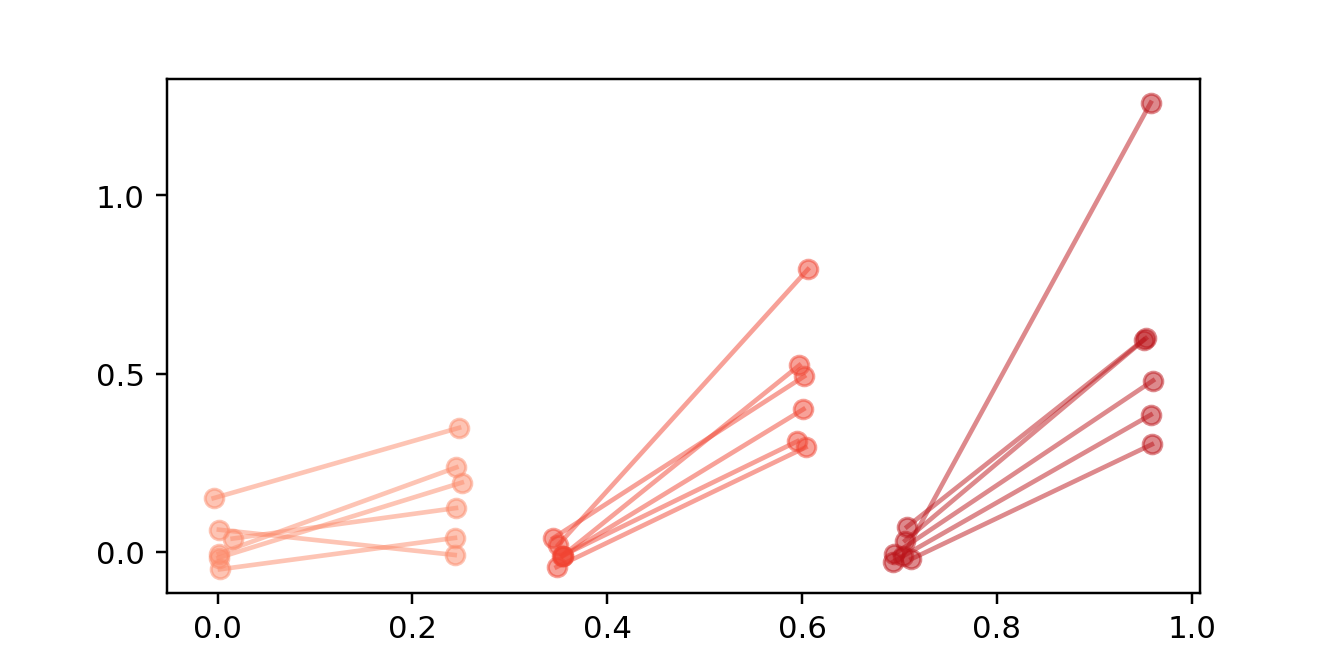

In [7]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)

shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, light_intensity=0, 
                           color=colors[0], start_x_position=0)

shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, light_intensity=1, 
                           color=colors[1], start_x_position=0.35)

shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, light_intensity=2, 
                           color=colors[2], start_x_position=0.7)
loc = plticker.MultipleLocator(base=0.5)  # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
savename = 'Fig4_F.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [8]:
p_values=[]

# median_before_stim.shape
# (6, 3, 1) # Animal, light intensity, group
shared_func.pairwise_t_tests(median_during_stim[:,0,0], median_before_stim[:,0,0], p_values) # 72 uW/mm2
shared_func.pairwise_t_tests(median_during_stim[:,1,0], median_before_stim[:,1,0], p_values) # 288 uW/mm2
shared_func.pairwise_t_tests(median_during_stim[:,2,0], median_before_stim[:,2,0], p_values) # 1151 uW/mm2

print('Holms-Bonferroni correction:')
shared_func.holms_bonferroni_correction(p_values)

lilliefors: 0.42073406902468063
T-Test
TtestResult(statistic=2.644530554088543, pvalue=0.04572622185816203, df=5)


lilliefors: 0.5688779429049697
T-Test
TtestResult(statistic=6.911960845116829, pvalue=0.0009716730532611775, df=5)


lilliefors: 0.010998814858752025
T-Test
TtestResult(statistic=4.284283517155465, pvalue=0.007831523547866238, df=5)


Holms-Bonferroni correction:
significantly different with:
current p: 0.0009716730532611775, current alpha: 0.016666666666666666
significantly different with:
current p: 0.007831523547866238, current alpha: 0.025
significantly different with:
current p: 0.04572622185816203, current alpha: 0.05


In [9]:
data = [[median_during_stim[:,0,0], median_before_stim[:,0,0]],
        [median_during_stim[:,1,0], median_before_stim[:,1,0]],
        [median_during_stim[:,2,0], median_before_stim[:,2,0]]
       ]

label_list_stat_export = [['During, 8uW/mm2', 'Before, 8uW/mm2'],
                          ['During, 47uW/mm2', 'Before, 47uW/mm2'],
                          ['During, 72uW/mm2', 'Before, 72uW/mm2']]
savename = 'Fig_4F'

shared_func.export_pairwise_dependent_test(data, label_list_stat_export,
                                           savepath=stat_savepath, savename=savename,
                                           parametric=True)

              Group  n      mean    median       STD       SEM  \
0   During, 8uW/mm2  6  0.154982  0.158205  0.120312  0.049117   
1   Before, 8uW/mm2  6  0.029379  0.015542  0.064977  0.026527   
2  During, 47uW/mm2  6  0.468277  0.445898  0.167884  0.068538   
3  Before, 47uW/mm2  6 -0.003716 -0.011861  0.025807  0.010536   
4  During, 72uW/mm2  6  0.603218  0.537609  0.312588  0.127614   
5  Before, 72uW/mm2  6  0.005554 -0.009280  0.034310  0.014007   

                              95% CI on the mean  DOF statistical test  \
0      (0.01667167574987352, 0.2932928849945903)  5.0       T-test rel   
1    (-0.04531770071093613, 0.10407632509373776)  NaN              NaN   
2      (0.27527800174901285, 0.6612769151112011)  5.0       T-test rel   
3  (-0.033384110092164035, 0.025951278980357224)  NaN              NaN   
4      (0.24386649260680998, 0.9625690935672131)  5.0       T-test rel   
5   (-0.033888364134320746, 0.04499601057069961)  NaN              NaN   

   t-statistic   p

# Figure 3 B and D

This uses the color defined above, that's why it is run after the dose response

In [10]:
filename = 'Fig4BC_ATR'
# read the numpy array
data_ATR = np.load(Path(filepath, filename + '.npy'))
# and also read the metadata to have everything in one place
with open(Path(filepath, filename + '.txt')) as f:
    metadata = f.read()
    print(metadata)

This numpy array contains the data to create Figure 3B/C 
which compares ATR+ and ATR- with stimulus duration of 10s and 
stimulus intensity of 1151uW/mm2 with stim light at 660nm. 

Output data is organized the following way:

1st dimension is 210. These are the datapoints 

2nd dimension is 8. These are: Time, Stim, df/f1, df/f2, df/f3, df/f4, df/f5, df/f6. 
Each df/f is a repeat on the same animal 

3rd dimension is 6, one for each animal 

4th dimension is 1. 

5th dimension is 2. The first contains ATR- data, the second contains ATR+ data.


<IPython.core.display.Javascript object>


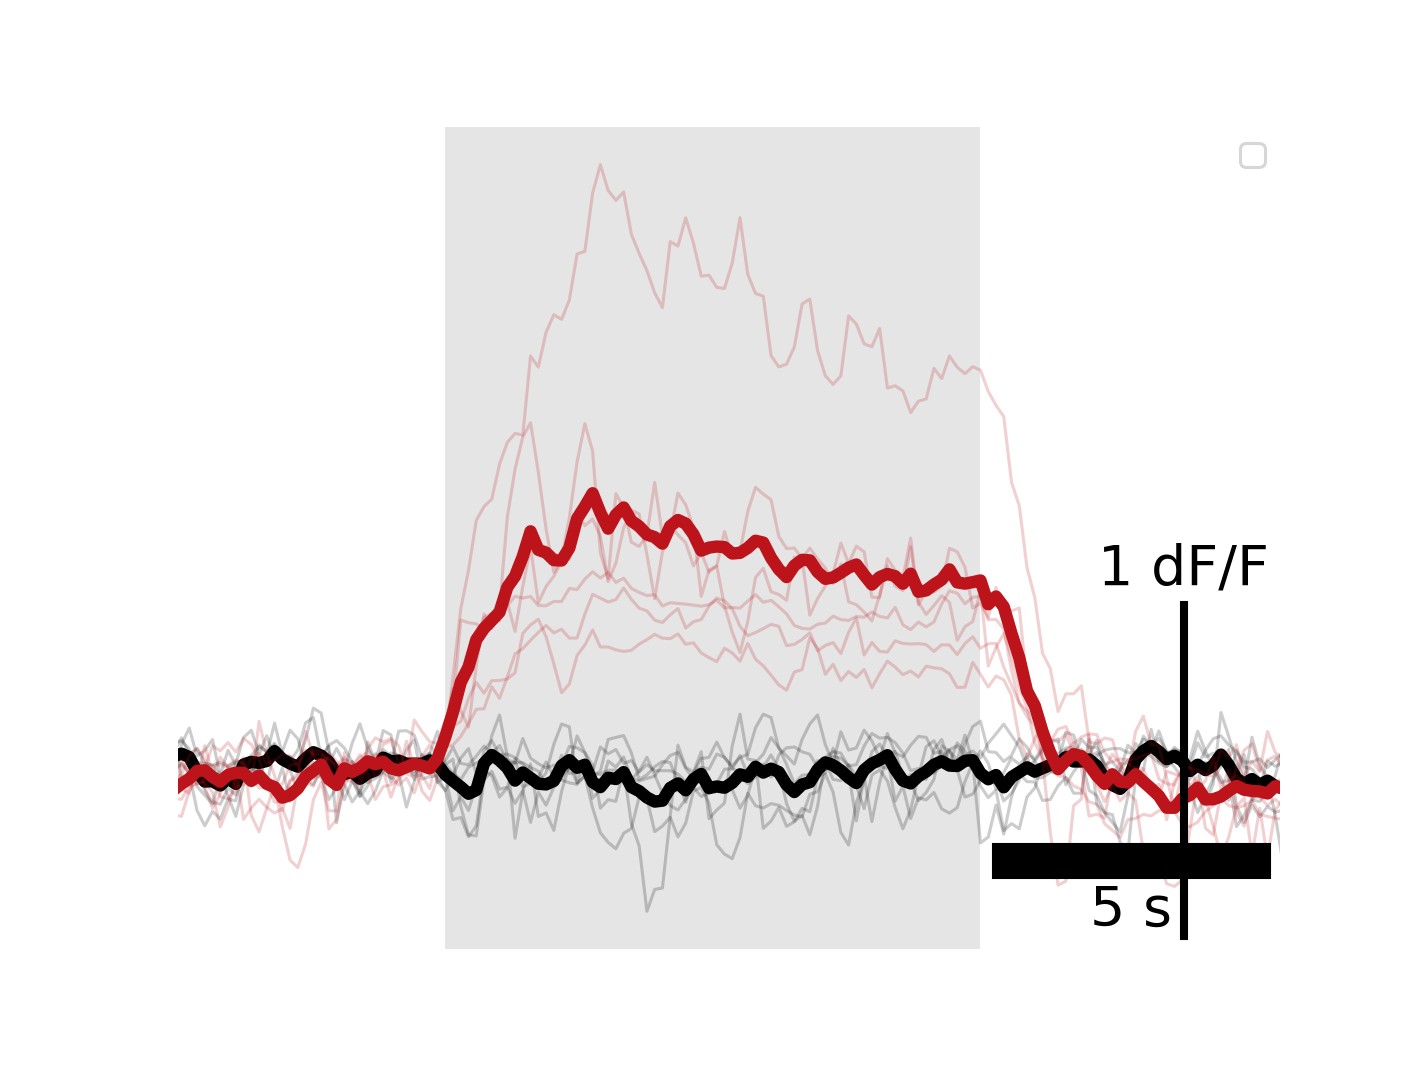

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [11]:
# Prepare the raw data for plotting
median_per_animal_ATR = shared_func.median_per_animal_func(aq_rate=aq_rate, data=data_ATR)
# Here stim_intensity is always 0
stim_intensity_ATR = 0

# Then, plot the trace plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Important for plotting: For ATR- we want to use black! 
colors_2 = ['black',
            colors[2],
            ]

for group in range(2):

    ax.plot(data_ATR[:,0,0,stim_intensity_ATR, group], median_per_animal_ATR[:,:,stim_intensity_ATR, group], 
            lw=1, zorder=1, color=colors_2[group], alpha=0.2)
    # and plot the mean of the median in bold
    ax.plot(data_ATR[:,0,0,stim_intensity_ATR, group], 
            np.mean(median_per_animal_ATR[:,:,stim_intensity_ATR, group], axis=1), 
            lw=4, zorder=1, color=colors_2[group])

# Plot stimulus
start_stim = np.where(data_ATR[:, 1, 0, stim_intensity_ATR, 0] > 0.1)[0][0]
stop_stim = np.where(data_ATR[:, 1, 0, stim_intensity_ATR, 0] > 0.1)[0][-1]
ax.axvspan(data_ATR[start_stim, 0, 0, stim_intensity_ATR, 0],
           data_ATR[stop_stim, 0, 0, stim_intensity_ATR, 0],
           lw=0, zorder=0,
           color='k',
           alpha=0.1)
ax.set_xlim(5, 25)

fontprops = fm.FontProperties(size=18)
scalebar_time = AnchoredSizeBar(ax.transData,
                                5, '5 s', 'lower right',
                                pad=0.1,
                                color='black',
                                frameon=False,
                                size_vertical=0.1,
                                fontproperties=fontprops)

scalebar_df = AnchoredSizeBar(ax.transData,
                              0.1, '1 dF/F', 'lower right',
                              pad=0.1,
                              color='black',
                              frameon=False,
                              size_vertical=1,
                              fontproperties=fontprops,
                              label_top=True)

ax.add_artist(scalebar_time)
ax.add_artist(scalebar_df)
ax.legend()
ax.axis('off')

savename = 'Fig4_B.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [12]:
# Median values before and during
# For readability explicitly state what is being taken
before_start_index = int(round(start_stim-aq_rate*1)) # one second before start
before_end_index = start_stim

during_start_index = int(round(start_stim)) # From beginning of stimulus...
during_end_index = int(round(stop_stim)) # ...until the end of the stimulus

median_before_stim_ATR = np.median(median_per_animal_ATR[before_start_index:start_stim, :, :],axis=0)
median_during_stim_ATR = np.median(median_per_animal_ATR[during_start_index:during_end_index, :, :],axis=0)

<IPython.core.display.Javascript object>


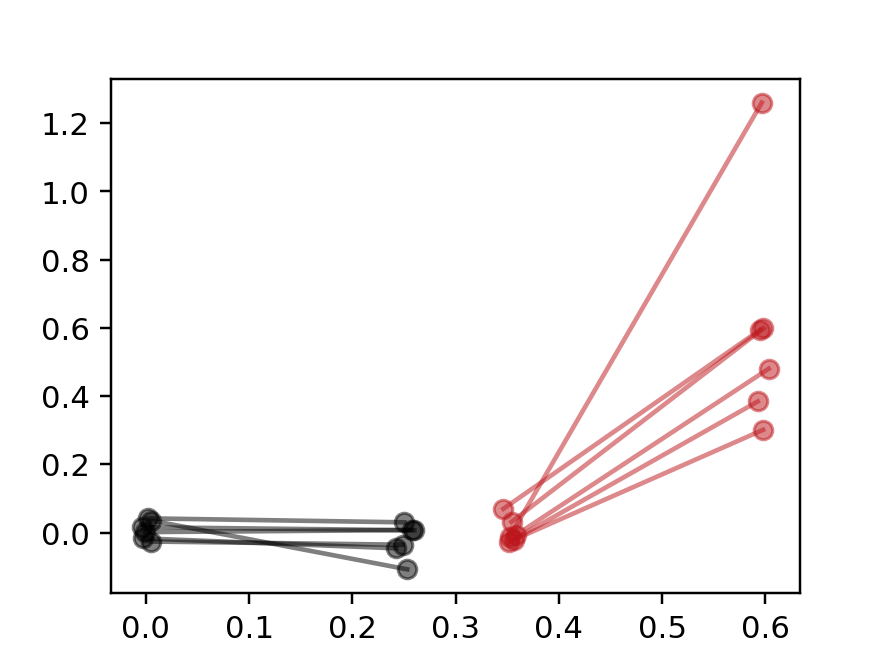

In [13]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)

shared_func.plot_connected_scatterplot(ax, median_before_stim_ATR, median_during_stim_ATR, 
                                       light_intensity=stim_intensity_ATR, 
                                       color=colors_2[0], start_x_position=0, group=0)

shared_func.plot_connected_scatterplot(ax, median_before_stim_ATR, median_during_stim_ATR, 
                                       light_intensity=stim_intensity_ATR,
                                       color=colors_2[1], start_x_position=0.35, group=1)

savename = 'Fig4_C.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [14]:
p_values=[]

# median_before_stim_ATR.shape
# (5, 1, 2) # Animal, light intensity, group
shared_func.pairwise_t_tests(median_during_stim_ATR[:,0,0], median_before_stim_ATR[:,0,0], p_values) # ATR-
shared_func.pairwise_t_tests(median_during_stim_ATR[:,0,1], median_before_stim_ATR[:,0,1], p_values) # ATR+

print('Holms-Bonferroni correction:')
shared_func.holms_bonferroni_correction(p_values)

lilliefors: 0.017222416059140697
T-Test
TtestResult(statistic=-1.4489902733950382, pvalue=0.20701583736153797, df=5)


lilliefors: 0.010998814858752025
T-Test
TtestResult(statistic=4.284283517155465, pvalue=0.007831523547866238, df=5)


Holms-Bonferroni correction:
significantly different with:
current p: 0.007831523547866238, current alpha: 0.025
NOT DIFFERENT!
current p: 0.20701583736153797, current alpha: 0.05


In [15]:
data = [[median_during_stim_ATR[:,0,0],median_before_stim_ATR[:,0,0]],
        [median_during_stim_ATR[:,0,1], median_before_stim_ATR[:,0,1]]
       ]

label_list_stat_export = [['During, ATR-', 'Before, ATR-'],
                          ['During, ATR+', 'Before, ATR+']]
savename = 'Fig_4C'

shared_func.export_pairwise_dependent_test(data, label_list_stat_export,
                                           savepath=stat_savepath, savename=savename,
                                           parametric=True)

          Group  n      mean    median       STD       SEM  \
0  During, ATR-  6 -0.024359 -0.014517  0.045641  0.018633   
1  Before, ATR-  6  0.008299  0.008342  0.025070  0.010235   
2  During, ATR+  6  0.603218  0.537609  0.312588  0.127614   
3  Before, ATR+  6  0.005554 -0.009280  0.034310  0.014007   

                             95% CI on the mean  DOF statistical test  \
0  (-0.07682789300096293, 0.028110634709964357)  5.0       T-test rel   
1   (-0.02052197642252223, 0.03711966184433779)  NaN              NaN   
2     (0.24386649260680998, 0.9625690935672131)  5.0       T-test rel   
3  (-0.033888364134320746, 0.04499601057069961)  NaN              NaN   

   t-statistic   p-value  Holm-Bonferroni corrected p-value significant  
0    -1.448990  0.207016                           0.207016          NO  
1          NaN       NaN                                NaN         NaN  
2     4.284284  0.007832                           0.015663         YES  
3          NaN       NaN   